<a href="https://colab.research.google.com/github/CallmeAk/Amazon-mobile-phone-Reviews/blob/main/Amazon_review_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazom review sentiment analysis

In [92]:
import os         # importing all requried libraries
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import pickle
import datetime
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [8]:
items = pd.read_csv('/content/20191226-items.csv')

In [9]:
reviews = pd.read_csv('/content/20191226-reviews.csv',on_bad_lines='skip')

In [10]:
items.head(10)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0
5,B001GQ3DJM,Nokia,Nokia 1680 Black Phone (T-Mobile),https://www.amazon.com/Nokia-1680-Black-Phone-...,https://m.media-amazon.com/images/I/41X4VeqkFO...,2.7,https://www.amazon.com/product-reviews/B001GQ3DJM,3,0.00,0.0
6,B0029F2O3A,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.00,0.0
7,B002AS9WEA,Samsung,Samsung a167 Prepaid GoPhone (AT&T),https://www.amazon.com/Samsung-a167-Prepaid-Go...,https://m.media-amazon.com/images/I/61OXcZ-oef...,2.9,https://www.amazon.com/product-reviews/B002AS9WEA,18,0.00,0.0
8,B002UHS0UI,Motorola,Verizon Wireless Motorola RAZR V3m - Silver,https://www.amazon.com/Verizon-Wireless-Motoro...,https://m.media-amazon.com/images/I/61pVtPaTkM...,2.7,https://www.amazon.com/product-reviews/B002UHS0UI,208,0.00,0.0
9,B002WTC1NG,Motorola,Motorola Barrage V860 Phone (Verizon Wireless),https://www.amazon.com/Motorola-Barrage-V860-V...,https://m.media-amazon.com/images/I/81k6Nq0KI1...,3.6,https://www.amazon.com/product-reviews/B002WTC1NG,352,139.99,0.0


In [11]:
reviews.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [12]:
final_data = pd.merge(reviews, items, how="left", left_on="asin", right_on="asin")
date = pd.to_datetime(final_data['date']) # converting date time to pandas datetime type
final_data.date = date
"""merging both data along asin column
   doing lest join insted of right because i want every row in reviews to be present in final data
   i case of right join if there is areview missing for a asin it will be replaced by NAN
   this data is only for visualisation
"""

'merging both data along asin column\n   doing lest join insted of right because i want every row in reviews to be present in final data\n   i case of right join if there is areview missing for a asin it will be replaced by NAN\n   this data is only for visualisation\n'

In [13]:
reviews['sentiment'] = reviews.rating.apply(lambda x : 1 if x>=3 else 0) # lets create a sentiment column wit an asumption that rating greater than 3 is a positive sentiment
reviews['review'] = reviews.title+reviews.body # adding both title and review columns

In [14]:
data = reviews[['review','sentiment']] #this is our final data with all columns we need

In [15]:
data

,review,sentiment
0,"Def not best, but not worstI had the Samsung A...",1
1,Text Messaging Doesn't WorkDue to a software i...,0
2,"Love This PhoneThis is a great, reliable phone...",1
3,"Love the Phone, BUT...!I love the phone and al...",1
4,"Great phone service and options, lousy case!Th...",1
...,...,...
17171,Wish I bought an s5The Galaxy S6 has a lot les...,0
17172,Wish I did this beforeI went with the regular ...,1
17173,Good phone with a great cameraUpgraded from an...,1
17174,"Great phone, great price.I am very happy with ...",1


In [16]:
data.isna().sum()

review       1
sentiment    0
dtype: int64

In [17]:
data = data.dropna()

#  Data Visualisation

## Pie chart to see brand distribution along our dataset

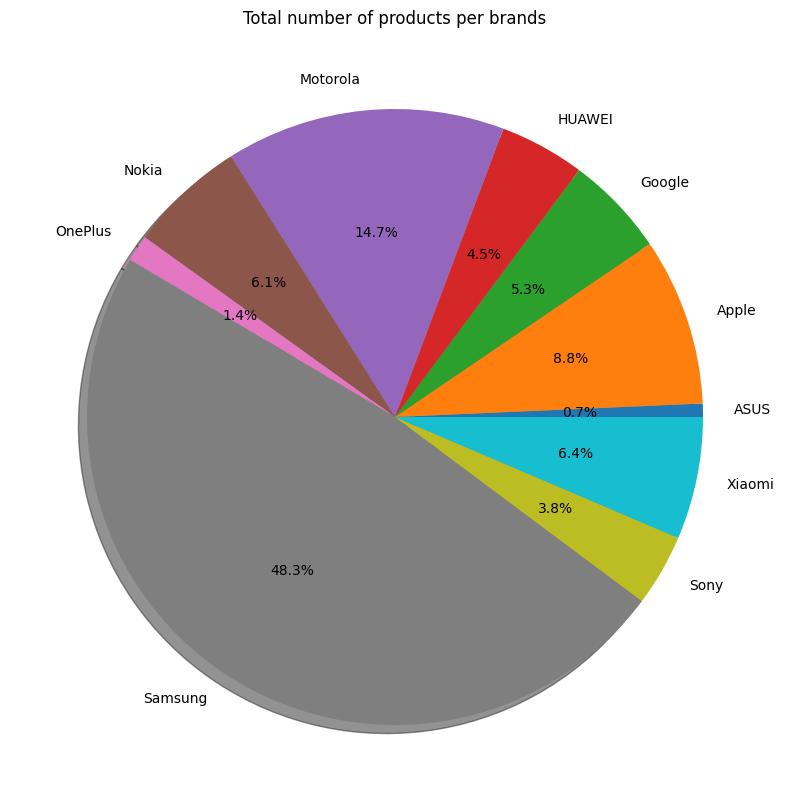

In [18]:
brand_size = items.groupby('brand').count()['asin']
labels = list(brand_size.index)
plt.figure(figsize=(15,10))
plt.title('Total number of products per brands')
plt.pie(brand_size,labels=labels,autopct='%1.1f%%',shadow=True)
plt.rcParams['text.color'] = 'b'
plt.rcParams['font.size'] = 25
plt.show()

### Lets group our reviews by brand see what is mean rating for a given brand

<ipython-input-19-9deaf676f655>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratings = items.groupby('brand').mean()['rating'].sort_values()


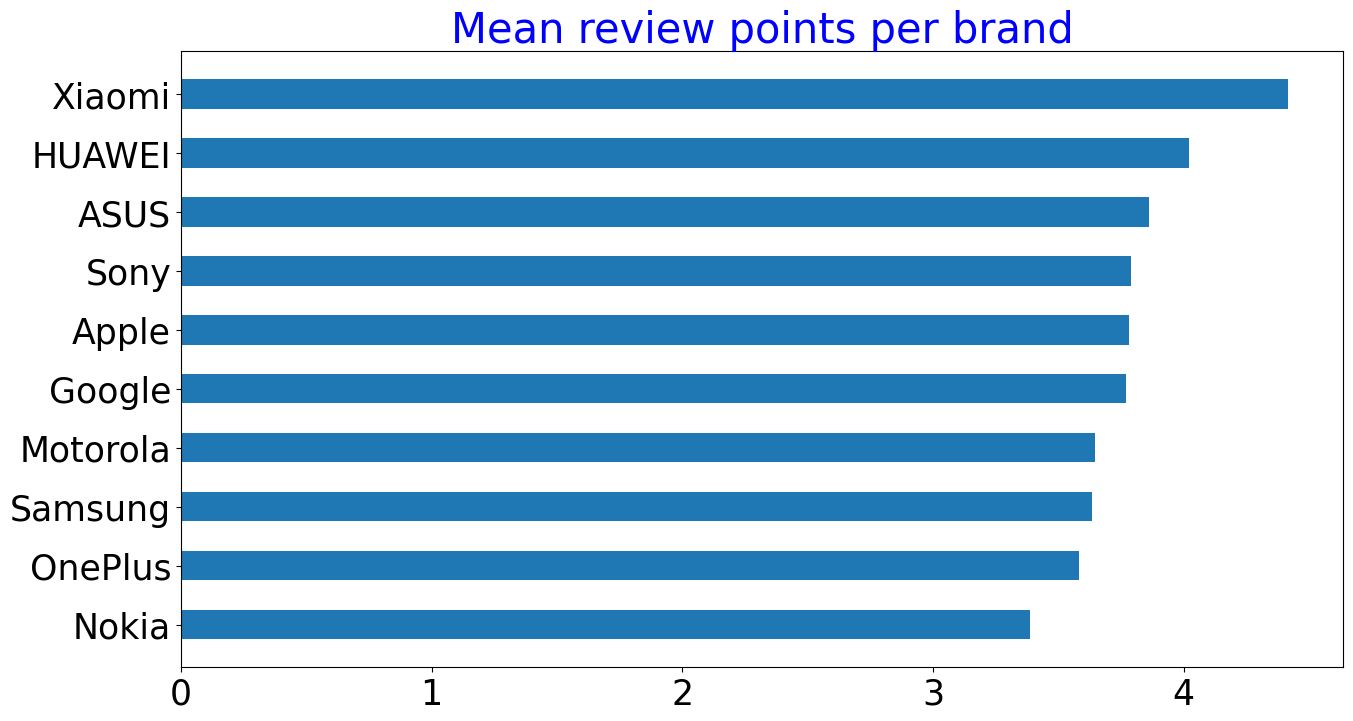

In [19]:
ratings = items.groupby('brand').mean()['rating'].sort_values()
label = list(ratings.index)
plt.figure(figsize=(15,8))
plt.title('Mean review points per brand')
plt.barh(label,ratings,height=0.5)
plt.show()

### Lets plot a bar chart to understand our data and see wether we have enough data for each rating values

<style>
td {
  font-size: 100px
    Lets plot a bar chart to understand our data and see wether we have enough data for each rating values
}
</style>


<BarContainer object of 5 artists>

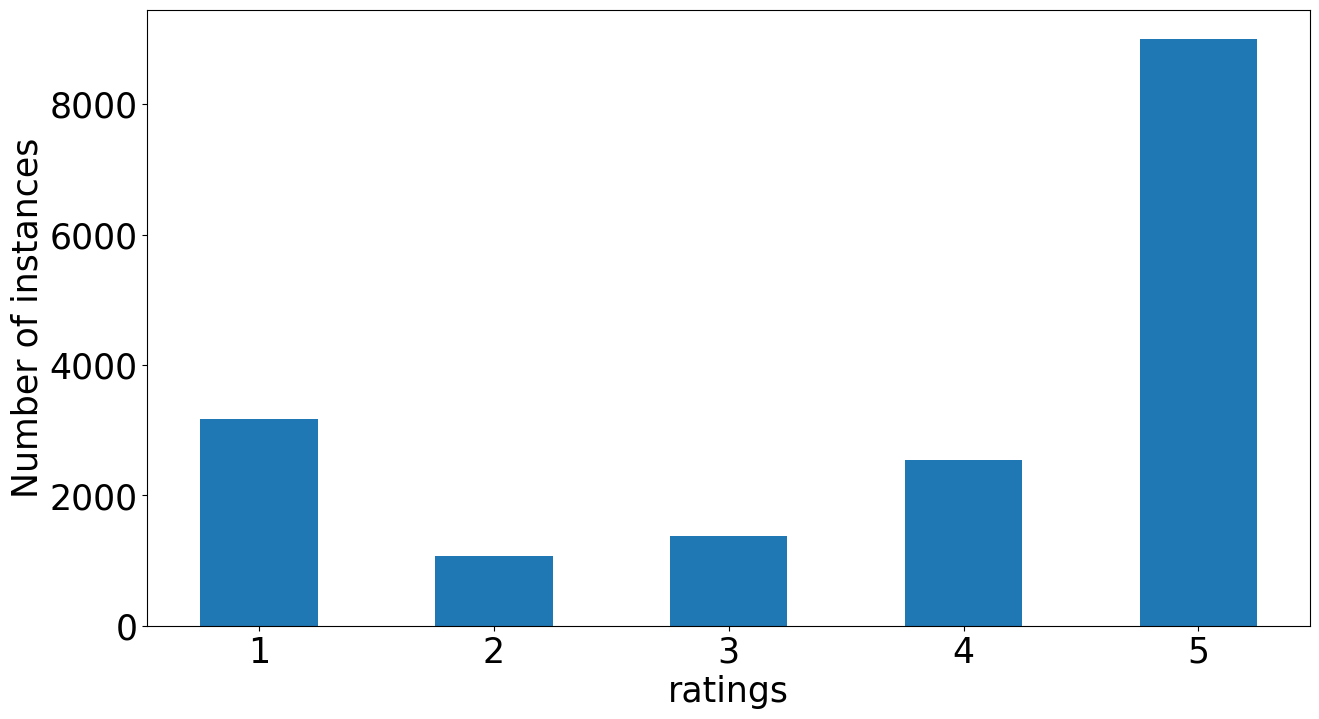

In [20]:
rating_group = reviews.groupby('rating').count()
plt.figure(figsize=(15,8))
plt.xlabel('ratings')
plt.ylabel('Number of instances')
plt.bar(rating_group.index,rating_group.asin,width=0.5)

### PLoting the number of reviews activity

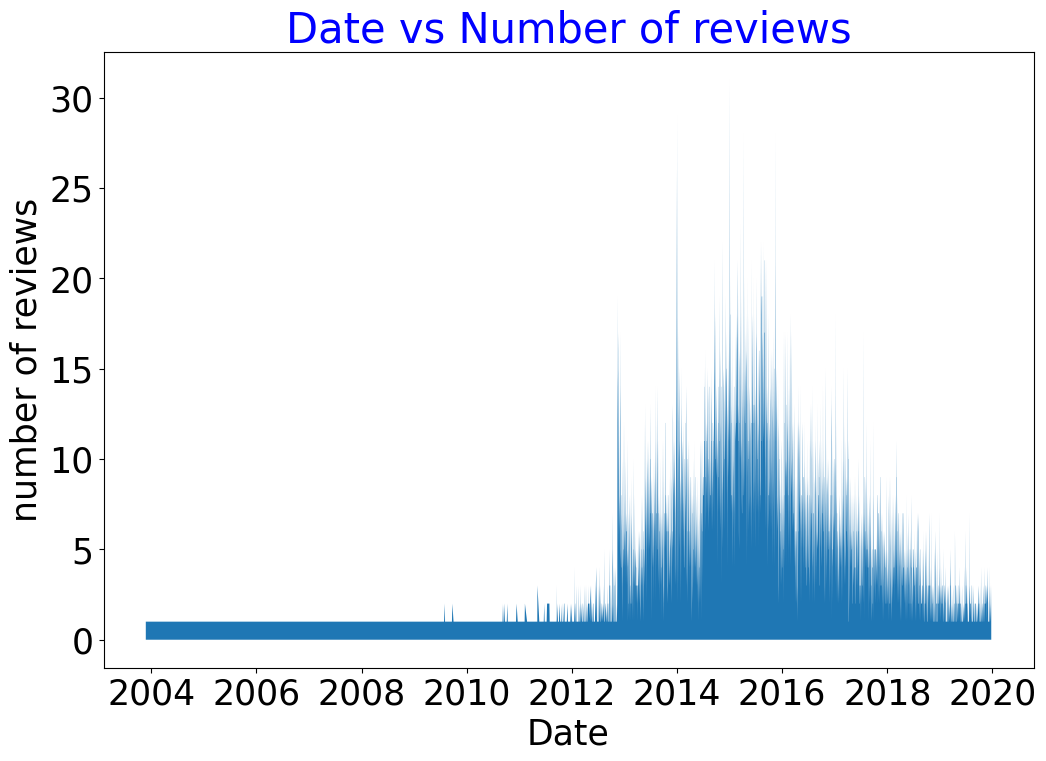

In [21]:
activity = final_data.groupby('date').count()['asin']
dates = activity.index
plt.figure(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('number of reviews')
plt.title('Date vs Number of reviews')
plt.fill_between(dates,activity)

### We want out data to have same amount of positive and negitive sentiment otherwise our model will be bias so lets see percentage of positve and negitive sentiment in our data

In [22]:
#example if your model have 75% positive data and 25% negitive data then our model will figur out if it predicts potive everytime it will be right 3 times for every 4 instances an dit will be very dificult
#for our model to learn and genralise the data

<BarContainer object of 2 artists>

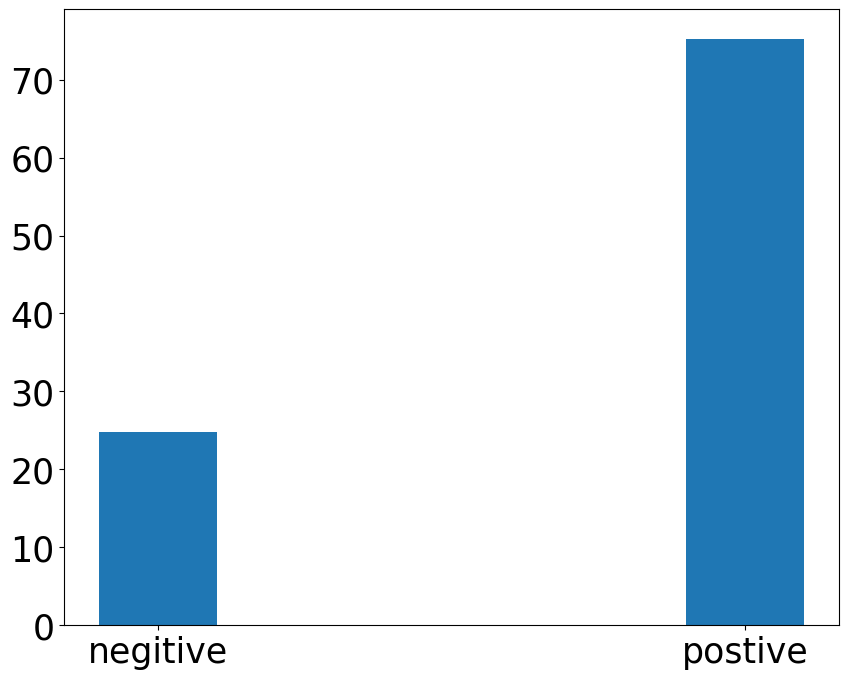

In [23]:
sent_count = data.groupby('sentiment').count()
neg_per = sent_count.review[0]*100/sent_count.review.sum()
pos_per = sent_count.review[1]*100/sent_count.review.sum()
plt.figure(figsize=(10,8))
#plt.annotate(neg_per,(0,30))
plt.bar(['negitive','postive'],[neg_per,pos_per],width=0.2)

In [24]:
neg_per,pos_per

(24.739446870451236, 75.26055312954877)

In [25]:
# as we can see there is huge diffrence in positive and negitive sentiment this will lead to many false positive results
#possible solutions 1) droping some postive values 2)collect more data

In [26]:
pos = data.loc[data.sentiment==1]
neg= data.loc[data.sentiment==0]

In [27]:
pos_text = " ".join(review for review in pos.review)

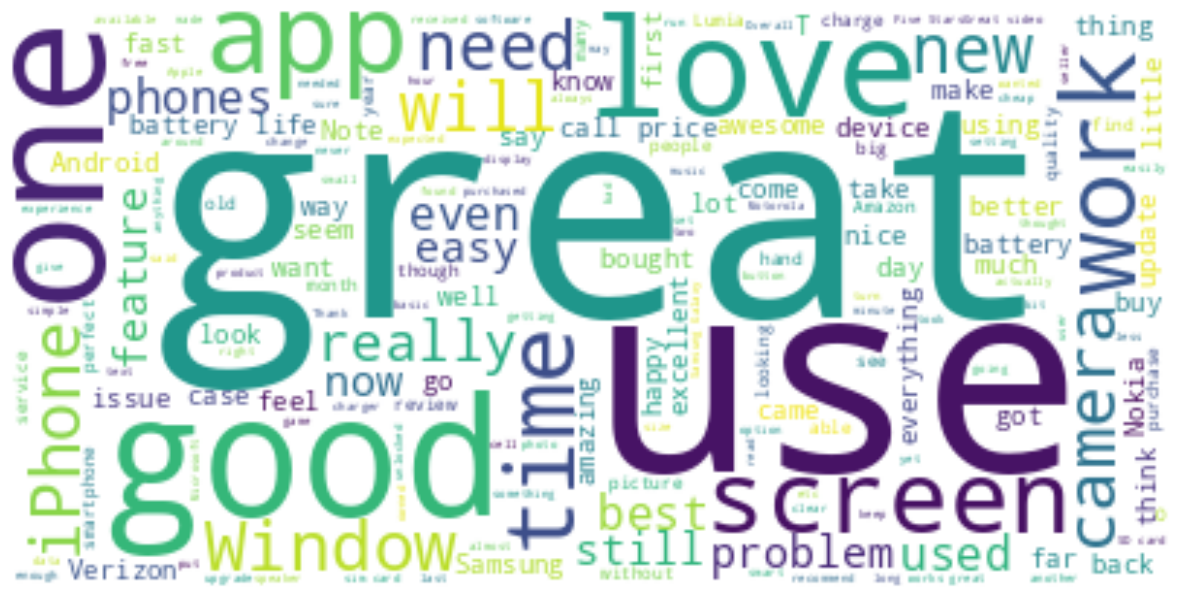

In [28]:
stopwords = set(STOPWORDS)
stopwords.update(['phone','the','thi'])
# Generate a word cloud image
pos_cloud = WordCloud(stopwords=stopwords,background_color="white").generate(pos_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
neg_text = " ".join(review for review in neg.review)

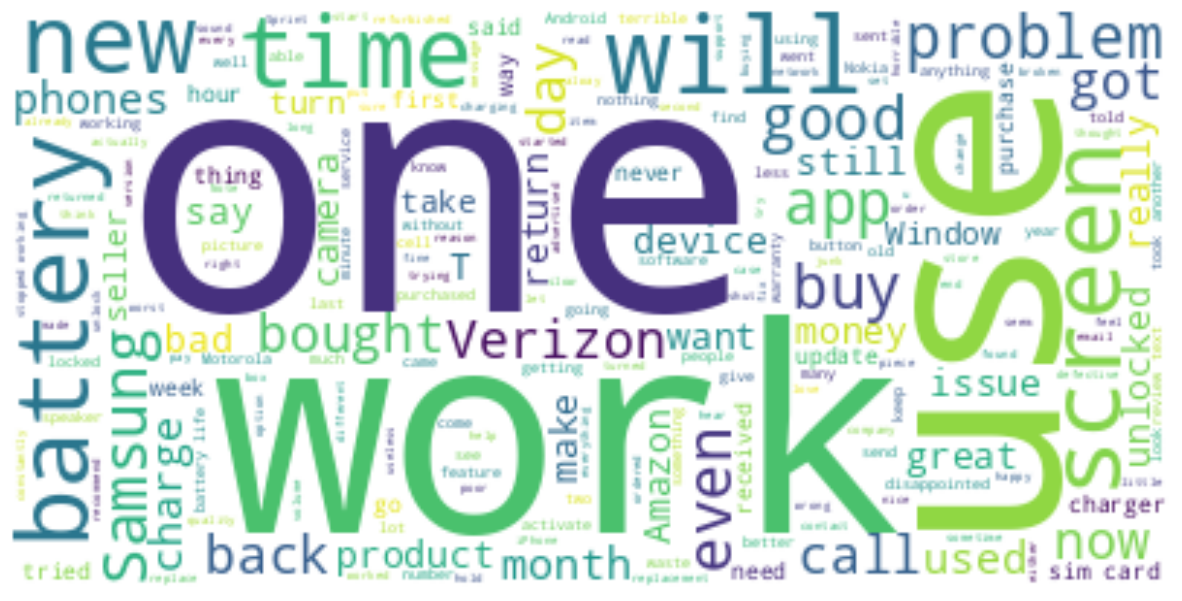

In [30]:
stopwords = set(STOPWORDS)
stopwords.update(['phone','ha','thi'])
# Generate a word cloud image
neg_cloud = WordCloud(stopwords=stopwords,background_color="white").generate(neg_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
pos.shape,neg.shape

((12926, 2), (4249, 2))

In [32]:
df = pd.concat([pos[:16000],neg[:16000]]) #lets only take 16k instance of both positive and negitive label

In [33]:
df

,review,sentiment
0,"Def not best, but not worstI had the Samsung A...",1
2,"Love This PhoneThis is a great, reliable phone...",1
3,"Love the Phone, BUT...!I love the phone and al...",1
4,"Great phone service and options, lousy case!Th...",1
5,"Worked great for meHello, I have this phone an...",1
...,...,...
17154,DO NOT BUY UNLESS YOU WANT TO LOSE ALL YOUR DA...,0
17155,BAD PHONENEVER US YOUR FINER PRINT TO LOCK YOU...,0
17161,I bought this phone for my mom's friend. After...,0
17168,I would like my $$$How should I open to instal...,0


## Features and target genration and text cleaning

In [34]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def data_genrator(df):
    ps = PorterStemmer()
    y = df.sentiment #target
    wo = []
    for i in range (0,len(df)):
        X = df.review.iloc[i]
        X = re.sub('[^a-zA-Z]',' ',X)
        X = X.lower()
        X = X.split()
        X = [ps.stem(w) for w in X if not w in stopwords.words('english')]
        X = ' '.join(X)
        wo.append(X)
    return wo,y

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
X,y = data_genrator(df)

In [36]:
cv = CountVectorizer(max_features=5000,max_df=0.7)#max_df=0.7 will skip featuers that are repeated in 75% of the instances
#choosing only 5000 featuers because data has around 30k featuers this will lead to curse of dimensionality

In [39]:
with open('tf_vac.pickle', 'wb') as f:      # saving vocubulary to transform data while predicting
    pickle.dump(cv, f, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
X = cv.fit_transform(X).toarray()

In [41]:
y = np.array(y)
X = np.array(X)

## train and test datasets creation

In [42]:
# i am choosing only 32000 instances from the data and creating train set, dev set and test set
# it is important to make sure thatr every set have equal number of both positive reviews mand negitive reviews to make sure that our model is not bias

In [43]:
train_size_index = 12000
dev_size_index = 14000
test_size_index = 16000
X_pos,X_neg = X[:16000],X[16000:]
y_pos,y_neg = y[:16000],y[16000:]
X_train = np.concatenate((X_pos[:train_size_index],X_neg[:train_size_index]))
X_dev = np.concatenate((X_pos[train_size_index:dev_size_index],X_neg[train_size_index:dev_size_index]))
X_test = np.concatenate((X_pos[dev_size_index:],X_neg[dev_size_index:]))

y_train = np.concatenate((y_pos[:train_size_index],y_neg[:train_size_index]))
y_dev = np.concatenate((y_pos[train_size_index:dev_size_index],y_neg[train_size_index:dev_size_index]))
y_test = np.concatenate((y_pos[dev_size_index:],y_neg[dev_size_index:]))

In [44]:
X_train.shape,X_dev.shape,X_test.shape

((13175, 5000), (2000, 5000), (2000, 5000))

In [45]:
train_data = list(zip(X_train,y_train))
random.shuffle(train_data)
X_train,y_train = zip(*train_data)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [46]:
dev_data = list(zip(X_dev,y_dev))
random.shuffle(dev_data)
X_dev,y_dev = zip(*dev_data)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

In [47]:
test_data = list(zip(X_test,y_test))
random.shuffle(test_data)
X_test,y_test = zip(*test_data)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [48]:
X_train.shape

(13175, 5000)

In [49]:
model = Sequential()

In [50]:
model.add(Dense(5000,input_shape=(5000,),activation='relu'))

In [51]:
model.add(Dropout(0.25))

In [52]:
model.add(Dense(128,activation='relu'))

In [53]:
model.add(Dense(1,activation='sigmoid'))

In [57]:
# adm = tf.keras.optimizers.Adam(learning_rate=1e-6) #defining learning rate and decay for better control

In [72]:
model.compile(loss = 'binary_crossentropy',metrics = ['accuracy'],optimizer ='adam')

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5000)              25005000  
                                                                 
 dropout (Dropout)           (None, 5000)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               640128    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,645,257
Trainable params: 25,645,257
Non-trainable params: 0
_________________________________________________________________


In [74]:
%load_ext tensorboard
logdir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#callback for tensorbord

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [75]:
loss_moniter = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
#this callback will moniter the validation loss and stops the epoch when there is no improvement greter than min_delta for patiience number of epoch

In [76]:
history = model.fit(X_train,y_train,epochs=200,batch_size=64,validation_data=(X_dev,y_dev),callbacks=[loss_moniter])

Epoch 1/200
206/206 [==============================] - 4s 10ms/step - loss: 0.1462 - accuracy: 0.9464 - val_loss: 0.8722 - val_accuracy: 0.7220
Epoch 2/200
206/206 [==============================] - 2s 10ms/step - loss: 0.0545 - accuracy: 0.9786 - val_loss: 2.2363 - val_accuracy: 0.6750
Epoch 3/200
206/206 [==============================] - 2s 9ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 2.9290 - val_accuracy: 0.7065
Epoch 4/200
206/206 [==============================] - 2s 9ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 4.8040 - val_accuracy: 0.6635
Epoch 5/200
206/206 [==============================] - 2s 9ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 3.6317 - val_accuracy: 0.7060
Epoch 6/200
206/206 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 4.6201 - val_accuracy: 0.7035
Epoch 7/200
206/206 [==============================] - 2s 9ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 4.0475 - val_accuracy: 0.73

In [77]:
model.save('model.h5')

In [78]:
model = tf.keras.models.load_model('model.h5')

Text(0, 0.5, 'Loss')

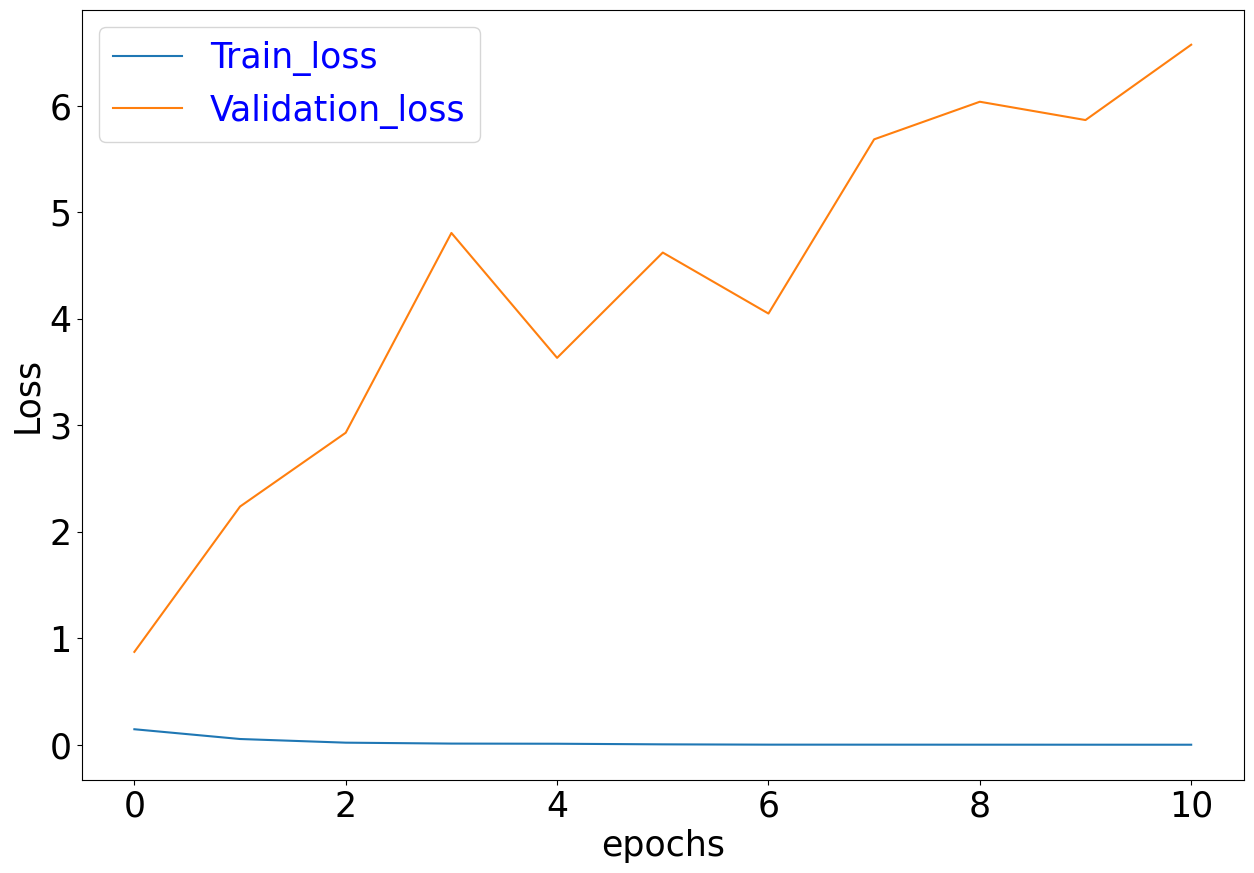

In [79]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_loss','Validation_loss'])
plt.rcParams['text.color'] = 'b'
plt.xlabel('epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

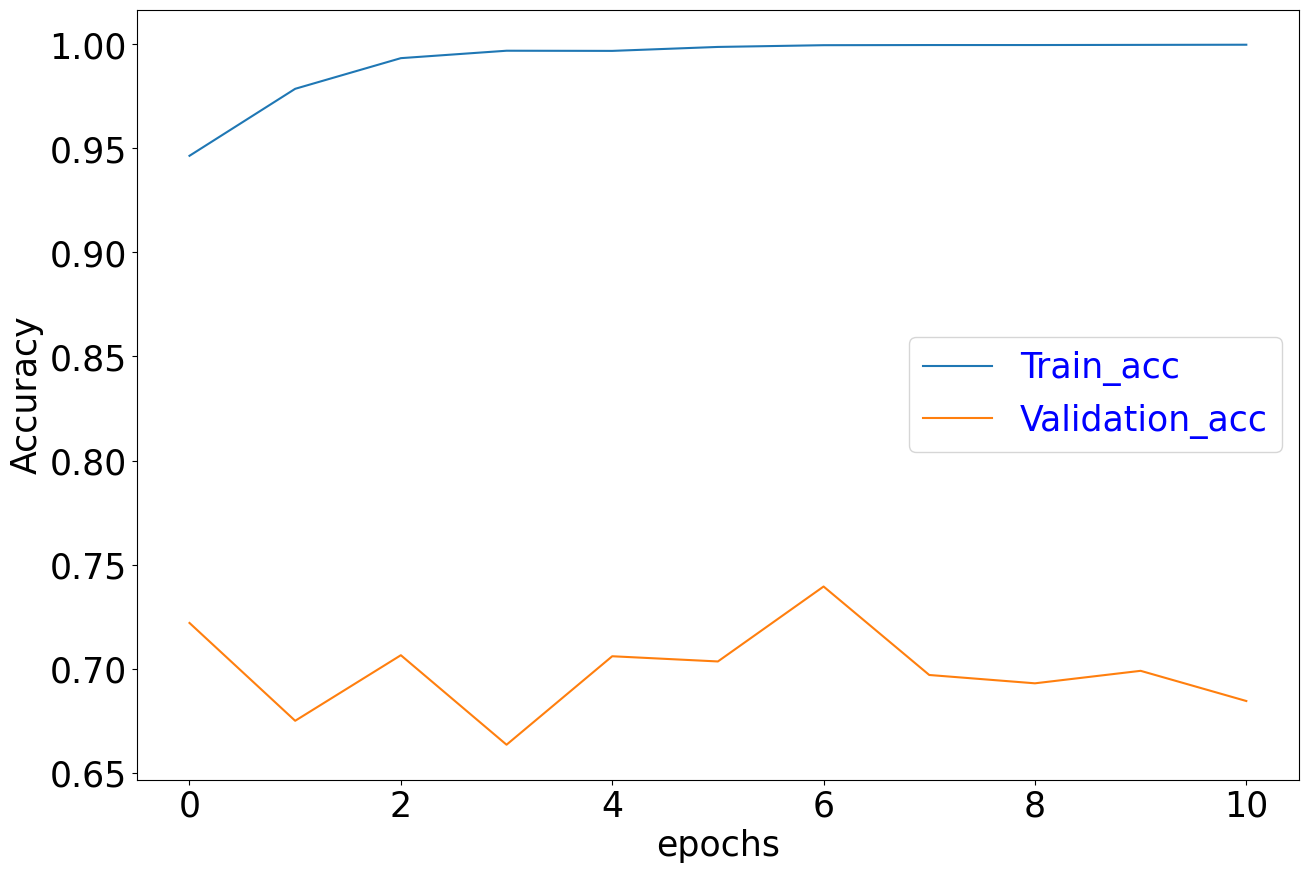

In [80]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_acc','Validation_acc'])
plt.rcParams['text.color'] = 'b'
plt.xlabel('epochs')
plt.ylabel('Accuracy')

In [85]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

63/63 [==============================] - 0s 2ms/step


In [86]:
y_pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [87]:
cm = confusion_matrix(y_test,y_pred)

In [88]:
cm

array([[1017,  983],
       [   0,    0]])

<Axes: >

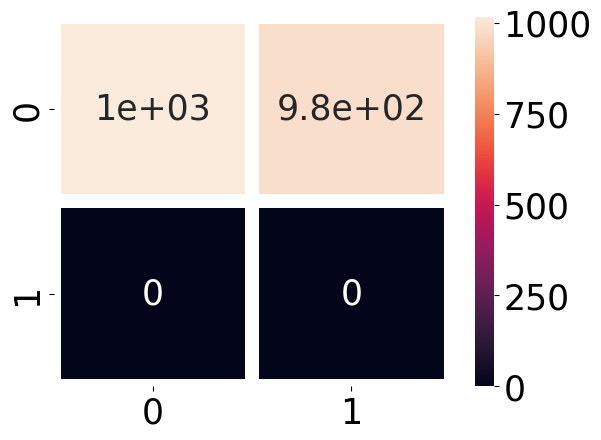

In [93]:
sns.heatmap(cm,annot=True,linewidths=10)

In [94]:
fpr,tpr,treshhold = roc_curve(y_test,y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [95]:
area = auc(fpr,tpr)

Text(0, 1, 'area under curve is nan')

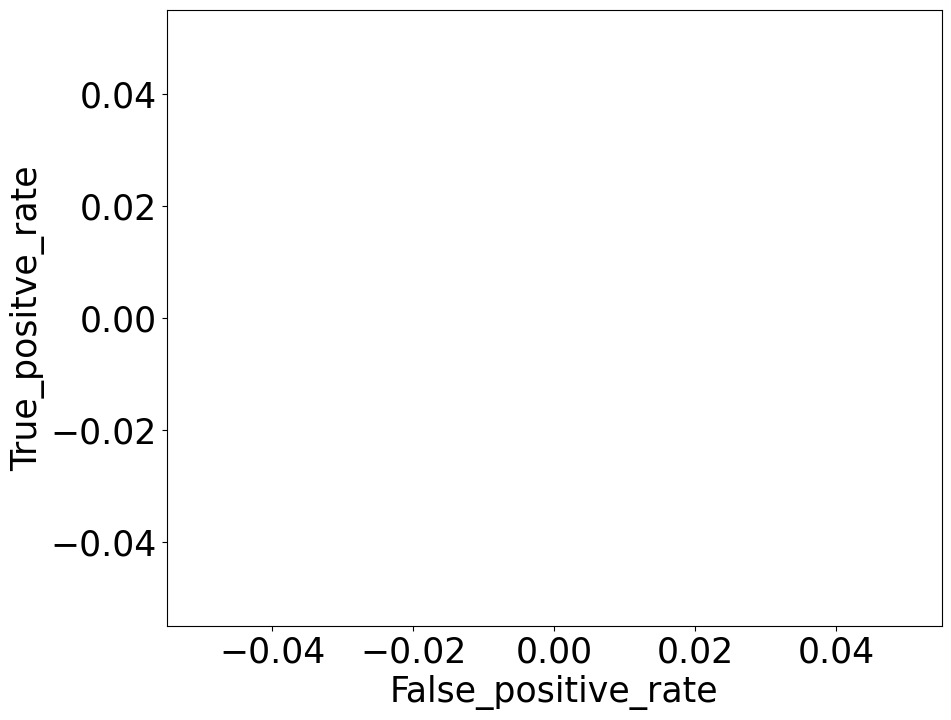

In [96]:
plt.figure(figsize=(10,8))
plt.plot(fpr,tpr)
plt.xlabel('False_positive_rate')
plt.ylabel('True_positve_rate')
plt.rcParams['font.size'] = 15
plt.annotate('area under curve is %s'%round(area,4),(0,1))